# Классификация

#### Данный ноутбук представляет собой краткий конспект теории и выполнение практических заданий

Структура:
  1. Реализация логистической регрессии. Матричные операции  
      1.1 Формирование класса по реализации алгоритма лог. регрессии   
      1.2 Добавление регуляризатора в логистическую регрессию
  2. Реализция логистичекой регрессии при помощи модели LogisticRegression библиотеки sklearn  
      2.1 Определение уровня доходов граждан в различных странах (датасет Adult Income)  
      2.2 Определение категории телефона (датасет train_mobile)

In [1]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import operator
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_curve, roc_auc_score, confusion_matrix)

## 1. Реализация логистической регрессии. Матричные операции

**Задача классификации:**  
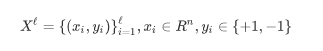  
Применим для решения разделяющий классификатор:  
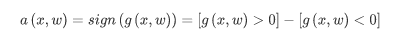  
- w — параметры модели, веса;  
- g(x, w) — разделяющая (дискриминантная) функция;  
- g(x, w) = 0 — уравнение разделяющей поверхности.  
Один из самых простых линейных классификаторов получается на основе линейной регрессии:  
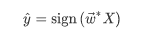

**Функция ошибки для логистической регрессии в случае бинарной классификации называется бинарной кросс-энтропией и выглядит следующим образом:**
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i))),$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}$$

Реализация логистической регрессии будет основана на оптимизации функции ошибки градиентным спуском.

В качестве данных будем использовать датасет о доходах граждан в различных странах [Adult Income](https://archive.ics.uci.edu/ml/datasets/Adult) и сделаем необходимую предобработку.

In [9]:
adult = pd.read_csv('adult.data', names = ['age', 'workclass', 'fnlwgt', 'education',
                                           'education-num', 'marital-status', 'occupation',
                                           'relationship', 'race', 'sex', 'capital-gain',
                                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
display(adult.head(3))
display(adult.info())
display(adult.describe())

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [10]:
# Избавимся от лишних признаков
adult.drop(['native-country'], axis = 1, inplace = True)

# Сконвертируем целевой столбец в бинарные значения
adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')

# Применим one-hot encoding для некоторых признаков
adult = pd.get_dummies(adult, columns=['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex'])
display(adult.head(3))

# Нормализуем признаки "вручную"
a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis = 0)) / a_features.std(axis = 0)
adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
display(adult.head(3))

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,...,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,race_ Amer-Indian-Eskimo,race_ Asian-Pac-Islander,race_ Black,race_ Other,race_ White,sex_ Female,sex_ Male
0,0.030671,-1.063611,1.134739,0.148453,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
1,0.837109,-1.008707,1.134739,-0.145920,-0.21666,-2.222153,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
2,-0.042642,0.245079,-0.420060,-0.145920,-0.21666,-0.035429,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [11]:
# Разбобьем таблицу данных на матрицы X и y, добавим фиктивный столбец единиц (bias линейной модели)
X = adult[list(set(adult.columns) - set(['salary']))].values
y = adult['salary'].values

X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [12]:
# Реализовуем функцию sigmoid
def sigmoid(X, theta):
    return 1. / (1. + np.exp(-X.dot(theta)))


# Реализуем функцию, вычисляющую градиент бинарной кросс-энтропии
def calc_binary_cross_entropy_grad(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(sigmoid(X, theta) - y)
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)   
    return theta


# Функция для подсчета метрик качества
def print_logistic_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'acc = {acc:.2f} F1-score = {f1:.2f}')

In [12]:
# Оптимизируем параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
theta

array([-3.18220152e+00,  6.08930383e-01,  1.14915955e+00,  1.42333149e+00,
       -4.28230037e-01,  8.11280626e-01,  6.11752440e-01,  9.78308166e-01,
       -3.15524980e-01, -7.81877921e-02,  7.95663040e-01,  3.24397258e-01,
        9.87311090e-01,  3.38583874e-01,  9.48510850e-01, -1.39716497e+00,
        5.53494533e-01,  8.58881427e-01,  4.08394474e-01,  1.05574662e+00,
        7.61509306e-01, -1.59850366e-02,  5.89057982e-01,  9.09710550e-01,
        2.58558666e-01,  6.21876481e-01,  8.98087390e-01,  9.74747564e-01,
        8.40399041e-01,  3.36378365e-01,  2.36520366e-01,  9.33962074e-01,
        9.64814314e-01,  6.93612812e-03,  3.30697269e-01,  9.95948149e-01,
        9.88443132e-04,  5.34420479e-01,  7.79500017e-02,  8.35398252e-01,
        3.95775461e-01,  6.22907129e-01, -2.97874470e-01,  6.90788800e-01,
        1.59897859e-01,  7.68917996e-01,  5.62066615e-01,  1.02543563e+00,
        3.38009780e-01, -6.37888463e-01,  6.46143233e-01, -1.29220590e-02,
        4.91984312e-01,  

In [42]:
# Сделаем предсказания на тренировочной выборке и посчитаем значение метрики accuracy и F1-score
y_pred = sigmoid(X, theta) > 0.5
print_logistic_metrics(y, y_pred)

# Разобьем выборку на train/valid, оптимизируем theta, сделаем предсказания и посчитаем ошибку F1-score
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)
theta = optimize(X_train, y_train, calc_binary_cross_entropy_grad, np.ones(m), 1., 300)
y_pred = sigmoid(X_valid, theta) > 0.5
print_logistic_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.65
acc = 0.85 F1-score = 0.66


In [81]:
# Изобразим ROC кривую
def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize = (4, 4))
    plt.plot(fpr, tpr, label = f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize = 12)
    plt.xlabel('False positive rate (FPR)', fontsize = 12)
    plt.ylabel('True positive rate (TPR)', fontsize = 12)
    plt.legend(fontsize = 12)

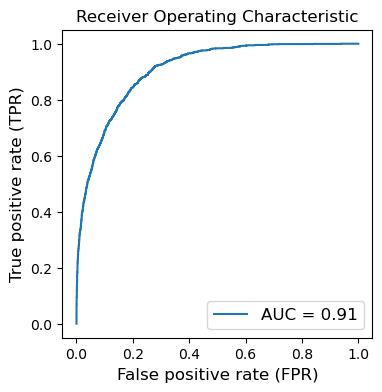

In [52]:
# Вычислим вероятности принадлежности к классу 1 для каждого объекта из валидационной выборки
y_pred_proba = sigmoid(X_valid, theta)
calc_and_plot_roc(y_valid, y_pred_proba)

### 1.1 Формирование класса по реализации алгоритма лог. регрессии

In [53]:
class RegOptimizer():
    def __init__(self, alpha, n_iters):
        self.theta = None
        self._alpha = alpha
        self._n_iters = n_iters
    
    def gradient_step(self, theta, theta_grad):
        return theta - self._alpha * theta_grad
    
    def grad_func(self, X, y, theta):
        raise NotImplementedError()

    def optimize(self, X, y, start_theta, n_iters):
        theta = start_theta.copy()
        for _ in range(n_iters):
            theta_grad = self.grad_func(X, y, theta)
            theta = self.gradient_step(theta, theta_grad)
        return theta
    
    def fit(self, X, y):
        m = X.shape[1]
        start_theta = np.ones(m)
        self.theta = self.optimize(X, y, start_theta, self._n_iters)
        
    def predict(self, X):
        raise NotImplementedError()

In [54]:
class LogReg(RegOptimizer):
    def sigmoid(self, X, theta):
        return 1. / (1. + np.exp(-X.dot(theta)))
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)

        return grad
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)
    
    def predict(self, X):
        if self.theta is None:
            raise Exception('You should train the model first')        
        y_pred = self.predict_proba(X) > 0.5     
        return y_pred

In [67]:
def prepare_adult_data():
    adult = pd.read_csv('adult.data', names = ['age', 'workclass', 'fnlwgt', 'education',
                                               'education-num', 'marital-status', 'occupation',
                                               'relationship', 'race', 'sex', 'capital-gain',
                                               'capital-loss', 'hours-per-week', 'native-country', 'salary'])
    
    # Избавимся от лишних признаков
    adult.drop(['native-country'], axis = 1, inplace = True)
    # Сконвертируем целевой столбец в бинарные значения
    adult['salary'] = (adult['salary'] != ' <=50K').astype('int32')
    # Сделаем one-hot encoding для некоторых признаков
    adult = pd.get_dummies(adult, columns = ['workclass', 'education', 'marital-status', 
                                             'occupation', 'relationship', 'race', 'sex'])
    
    # Нормализуем нуждающиеся в этом признаки
    a_features = adult[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
    norm_features = (a_features - a_features.mean(axis = 0)) / a_features.std(axis = 0)
    adult.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
    # Разобьем таблицу данных на матрицы X и y
    X = adult[list(set(adult.columns) - set(['salary']))].values
    y = adult['salary'].values

    # Добавим фиктивный столбец единиц (bias линейной модели)
    X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
    
    return X, y

In [68]:
logreg = LogReg(1., 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [69]:
# Разобьем выборку на train / valid, оптимизируем theta, сделаем предсказания и посчитаем F1-score
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logistic_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.64


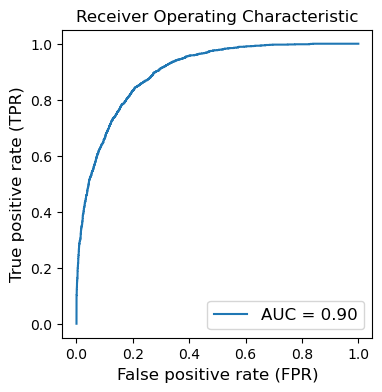

In [70]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

### 1.2 Добавление регуляризатора в логистическую регрессию

В случаях линейной и логистической регрессии к функции ошибки добавляется регуляризующая часть:
$$\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $\theta$ — вектор параметров линейной модели без фиктивного признака (intercept / bias term), $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации (подбираемый).

Функция ошибки для логистической регрессии в случае бинарной классификации с регуляризатором записывается следующим образом:
$$L=-\frac{1}{n}(y_i \log h_{\theta}(x_i) + (1-y_i) \log(1-h_{\theta}(x_i)))+\frac{\lambda}{2m}\sum_{j}^{m}{\theta_j^2},$$
где $x_i$ — вектор признаков $i$-го примера из обучающей выборки, $y_i$ — истинный класс для соответствующего примера (0 или 1), $n$ — число примеров в обучающей выборке, $m$ — количество нефиктивных признаков, $\lambda$ — параметр регуляризации, $h_{\theta}(x)$ — sigmoid функция, равная:
$$h_{\theta}(x)=\frac{1}{1+\exp^{-\theta x}},$$
где $\theta$ — вектор параметров логистической регрессии, $x$ - вектор признаков объекта из выборки.

Соответствующий градиент функции ошибки равен:
$$\nabla L=\frac{1}{n}\sum_{i=1}^{n}{(h_{\theta}(x_i)-y_i)x_i}+\frac{\lambda}{m}\sum_{j}^{m}{\theta_j}$$

In [71]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [72]:
logreg = LogRegRegularized(alpha = 1., lambd = 1., n_iters = 300)
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [73]:
# Разобьем выборку на train / valid, оптимизируем theta, сделаем предсказания и посчитаем F1-score
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_valid)

print_logistic_metrics(y_valid, y_pred)

acc = 0.85 F1-score = 0.65


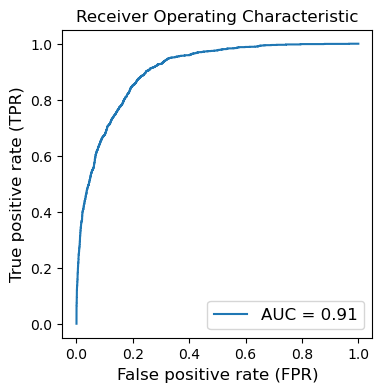

In [74]:
y_pred_proba = logreg.predict_proba(X_valid)
calc_and_plot_roc(y_valid, y_pred_proba)

Регуляризация позволяет избежать переобучения. Это наиболее часто используемый способ борьбы с переобучением, поскольку он прост в реализации и не сильно влияет на скорость сходимости алгоритма.  

## 2. Реализция логистичекой регрессии при помощи модели LogisticRegression библиотеки sklearn


### 2.1 Определение уровня доходов граждан в различных странах

Построим классификатор, который будет определять уровень доходов граждан в различных странах. Для этого воспользуемся датасетом Adult Income. Обучим модель логистической регрессии из библиотеки sklearn на всей выборке с параметрами по умолчанию. Посчитаем F1 score.

In [75]:
X, y = prepare_adult_data()

model = LogisticRegression().fit(X,y)
y_pred = model.predict(X)

print_logistic_metrics(y, y_pred)

acc = 0.85 F1-score = 0.66


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [81]:
# Посчитаем confusion matrix
confusion_matrix(y, y_pred)

array([[23028,  1692],
       [ 3128,  4713]], dtype=int64)

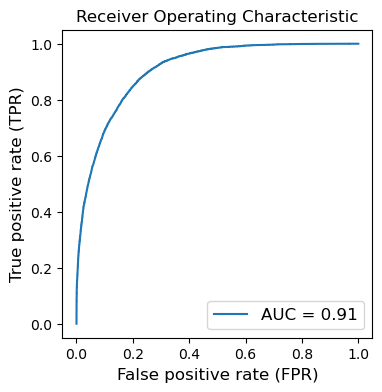

In [83]:
# Посчитаем значение ROC-кривой (receiver operating characteristic) и значение площади под кривой AUC (area under the curve)
y_pred_proba = model.predict_proba(X)
calc_and_plot_roc(y, y_pred_proba[:, 1])

#### Переберем коэффициенты L2-регуляризации от 0.01 до 1 с шагом  0.01 и определим, на каком из них модель логистической регрессии из sklearn даёт наибольший  F1-score.


In [84]:
class LogRegRegularized(LogReg):
    def __init__(self, alpha, lambd, n_iters):
        super(LogRegRegularized, self).__init__(alpha, n_iters)
        self._lambd = lambd
    
    def grad_func(self, X, y, theta):
        n = X.shape[0]
        grad = 1. / n * X.transpose().dot(self.sigmoid(X, theta) - y)
        grad_term = self._lambd * np.mean(theta)

        return grad + grad_term

In [85]:
# Создадим словаь для коэффициентов lambda и полученного значения метрики F1_score
lambd_dict = {} 

# Создадим массив коэффициентов lambda от 0.01 до 1 с шагом 0.01 
lambd_list = np.arange(0.01, 1, 0.01)

# Подготовим матрицы X и y, разделим выборки на обучающую и валидационную
X, y = prepare_adult_data()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

In [91]:
# Функция для перебора коэффициентов lambda и вычисления метркии F1_score
def lambd_function(X_train, X_valid, y_train, y_valid):
    for i in range(0, len(lambd_list)):
        logreg = LogRegRegularized(alpha = 1, lambd = lambd_list[i], n_iters = 300)
        logreg.fit(X_train, y_train)
        y_pred = logreg.predict(X_valid)
        F1 = round(f1_score(y_valid, y_pred), 3)
        lambd_dict[round(lambd_list[i], 2)] = F1
    return lambd_dict

In [110]:
max_lambd = max(lambd_dict, key = (lambda k: lambd_dict[k]))
max_f1 = round(max(lambd_dict.values()), 2)
print(f'Максимальное значение F1_score: {max_f1}. Значение коэффициента lambda: {round(max_lambd,2)}')
print(max(lambd_dict, key = lambd_dict.get))

Максимальное значение F1_score: 0.64. Значение коэффициента lambda: 0.03
0.03


In [111]:
max_lambd = max(lambd_dict, key = (lambda k: lambd_dict[k]))
max_f1 = max(lambd_dict.values())
print(f'Максимальное значение F1_score: {max_f1}. Значение коэффициента lambda: {max_lambd}')

import operator
x = max(lambd_dict.items(), key = operator.itemgetter(1))
print(x)       # напечатать пару ('C', 3)
print(x[0])    # напечатать ключ 'C'

Максимальное значение F1_score: 0.644. Значение коэффициента lambda: 0.03
(0.03, 0.644)
0.03


### Создадим новый датасет adult_changed 
**- заменим в столбце native-country страны, у которых меньше ста записей, на other,**  
**- поменяем этот столбец на dummy-переменные,**  
**- обучим классификатор на всей выборке и посчитаем f1-score.**


In [112]:
adult_changed = pd.read_csv('adult.data', names = ['age', 'workclass', 'fnlwgt', 'education',
                           'education-num', 'marital-status', 'occupation',
                           'relationship', 'race', 'sex', 'capital-gain',
                           'capital-loss', 'hours-per-week', 'native-country', 'salary'])
adult_changed.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [113]:
# Определим список стран, у которых меньше ста записей
other_contries = adult_changed['native-country'].value_counts()[adult_changed['native-country'] \
                .value_counts() < 100].index.tolist()

# Создадим функцию для трансформации столбца native_country    
def native_country_change(row):
        if str(row['native-country']) in other_contries:
            return 'other'
        else:
            return row['native-country']

        
adult_changed['native-country'] = adult_changed.apply(lambda x: native_country_change(x), axis = 1)
adult_changed['native-country'].value_counts()

 United-States    29170
other              1389
 Mexico             643
 ?                  583
 Philippines        198
 Germany            137
 Canada             121
 Puerto-Rico        114
 El-Salvador        106
 India              100
Name: native-country, dtype: int64

In [511]:
# Применим к столбцу native-country трансформацию one-hot encoding
adult_changed = pd.get_dummies(adult_changed, columns = ['native-country','workclass', 'education', 'marital-status', 
                                                         'occupation', 'relationship', 'race', 'sex'])

# Сконвертируем целевой столбец в бинарные значения
adult_changed['salary'] = (adult_changed['salary'] != ' <=50K').astype('int')

# Нормализуем нуждающиеся в этом признаки
a_features = adult_changed[['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']].values
norm_features = (a_features - a_features.mean(axis = 0)) / a_features.std(axis = 0)
adult_changed.loc[:, ['age', 'education-num', 'hours-per-week', 'fnlwgt', 'capital-gain', 'capital-loss']] = norm_features
    
# Разобьем таблицу данных на матрицы X и y
X = adult_changed[list(set(adult_changed.columns) - set(['salary']))].values
y = adult_changed['salary'].values

# Добавим фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

# Обучим классификатор на всей выборке и посчитаем значение метрик Accuracy и f1-score
model = LogisticRegression().fit(X,y)
y_pred = model.predict(X)

print_logistic_metrics(y, y_pred)  

acc = 0.85 F1-score = 0.66


C:\DsAngelina\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 2.2 Определение категории телефона 

**Построим классификатор для определения категории телефона.**  Для этого будем использовать датасет  train_mobile, который  содержит информацию о параметрах мобильных телефонов. Переменная price_range отвечает за то, к какой категории относится телефон: 1 — дорогие, 0 — дешевые.

In [116]:
# Загрузим датасет и посмотрим на данные
mobile = pd.read_csv('train_mobile.csv', sep = ';')
display(mobile.head(3))
display(mobile.info())

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,0
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,1
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

None

**Отбор признаков**  
С помощью анализа корреляции выберем признаки, у которых наибольшая взаимосвязь с целевой переменной. Эти признаки будут использоваться для предсказания категории телефона.

<AxesSubplot:>

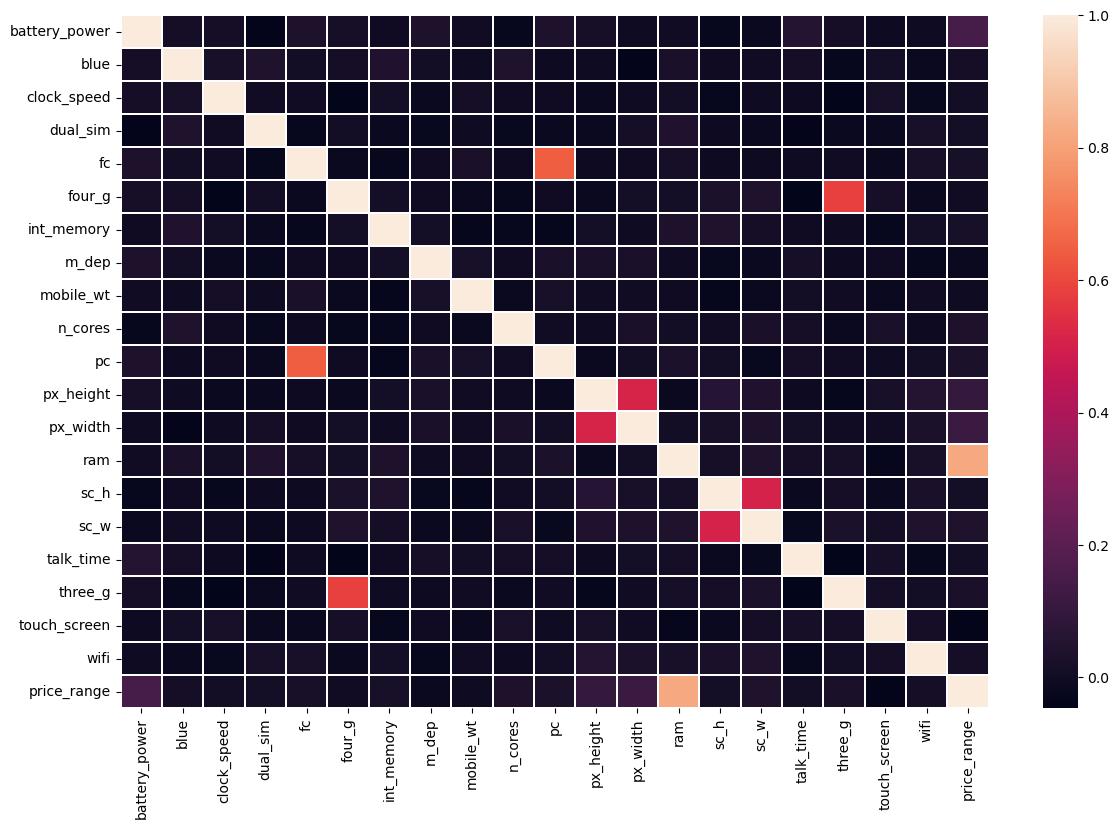

In [21]:
plt.figure(figsize = (14,9))
sns.heatmap(mobile.corr(), linewidth = 0.2)

Выберем признаки, которые имеют наиболее высокий показатель корреляции с целевой переменной, а именно: battery_power, px_height, px_width, ram, touch_screen

- Разобьем выборку на тестовую и обучающую, обучим модель логистической регрессии.  
- В качестве предикторов возьмем пять ранее отобранных признаков.  
- Посчитаем метрику Precision, которая покажет, какая доля телефонов, обозначенных классификатором как дорогие, действительно относится к этой категории. 

In [124]:
X, y = mobile[['battery_power', 'px_height', 'px_width', 'ram', 'touch_screen']], mobile['price_range']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 31)

Model = LogisticRegression().fit(X_train, y_train)
y_pred = Model.predict(X_val)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
acc = accuracy_score(y_val, y_pred)

print(f'Precision: {precision:.2f} \nRecall: {recall:.2f} \nF1_score: {f1:.2f} \nAccuracy_score: {acc:.2f}')

Precision: 0.99 
Recall: 0.99 
F1_score: 0.99 
Accuracy_score: 0.99
